<a href="https://colab.research.google.com/github/Avery1493/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/Quinn_224_LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')
train.shape, test.shape

((59400, 41), (14358, 40))

In [0]:
#Spliting Train dat in to train and val
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.20, random_state=42)
train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

# Wrangle Function

In [0]:
#Columns not need 
to_leave_out = ['amount_tsh', 'wpt_name', 'num_private',
                'subvillage','lga', 'ward','recorded_by','scheme_name',
                'extraction_type','extraction_type_group','management',
                'payment','water_quality','quantity','source_type','waterpoint_type']

#Other
fine = ['basin', 'region_code', 'district_code',
        'extraction_type_class','quality_group','quantity_group',
        'source', 'source_class', 'waterpoint_type_group']

top = ['funder','installer','scheme_management']
nans = ['longitude', 'latitude','gps_height','population',
        'construction_year', 'management_group','payment_type']
other = ['id', 'region', 'date_recorded']
boolean = ['public_meeting','permit']

In [0]:
import numpy as np

def wrangle(X):
  #make copy
  X = X.copy()
  
  #Fixing latitude outlier
  X['latitude'] = X['latitude'].replace(-2e-08, 0)
  #Making True/False Zero/One
  for col in boolean:
    X[col] = X[col].replace({True:1, False:0,'':0})

  #Replacing zeors with NaNs
  columns_with_zeros = nans
  for col in columns_with_zeros:
    X[col] = X[col].replace(0, np.nan)

  #Deleting Duplicate or Constant Columns
  X = X.drop(columns = to_leave_out)
  
  #High Cardinality Features
  high_cardinality = top
  for col in high_cardinality:
    top5 = X[col].value_counts()[:5].index
    X.loc[~X[col].isin(top5), col] = 'Other'
  
  # Convert date_recorded to datetime
  X['date_recorded'] = pd.to_datetime(X['date_recorded'],
                                      infer_datetime_format=True)
    
  # Extract components from date_recorded, then drop the original column
  X['year_recorded'] = X['date_recorded'].dt.year
  X = X.drop(columns='date_recorded')
    
  # Engineer feature: years from construction_year to date_recorded
  X['years'] = X['year_recorded'] - X['construction_year']
  X['years_MISSING'] = X['years'].isnull()

  return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)
train.shape, val.shape, test.shape

((47520, 27), (11880, 27), (14358, 26))

# Features

In [0]:
#TARGET is status group
target = 'status_group'

#Drop target and id columns 
train_features = train.drop(columns=[target, 'id'])

#Numerical Columns
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

#Catergorical Columns
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 50].index.tolist()

#FEATURES
features = numeric_features + categorical_features

print(len(features),'Features')
print(features)

25 Features
['gps_height', 'longitude', 'latitude', 'region_code', 'district_code', 'population', 'construction_year', 'year_recorded', 'years', 'funder', 'installer', 'basin', 'region', 'public_meeting', 'scheme_management', 'permit', 'extraction_type_class', 'management_group', 'payment_type', 'quality_group', 'quantity_group', 'source', 'source_class', 'waterpoint_type_group', 'years_MISSING']


In [0]:
#Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]

# Random Forrest Model

In [0]:
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix

In [0]:
%%time
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=1000, max_depth=20,
                           random_state=42, n_jobs=-1)
)

k=10
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='accuracy')
print(f'Accuracy for {k} folds:', scores)

Accuracy for 10 folds: [0.8013468  0.80955387 0.81186869 0.80239899 0.80997475 0.80555556
 0.8047138  0.81313131 0.809133   0.80513468]
CPU times: user 1min, sys: 7.05 s, total: 1min 7s
Wall time: 11min 4s


In [0]:
print('Train Accuracy', scores.mean())

Train Accuracy 0.8072811447811448


# Confusion Matrix

In [0]:
%%time
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=1000, max_depth=20,
                           random_state=42, n_jobs=-1)
)

# Fit on train
pipeline.fit(X_train, y_train)

# Score on train
print('Training Accuracy', pipeline.score(X_train, y_train))

# Predict on val
y_pred = pipeline.predict(X_val)



Training Accuracy 0.9442340067340067
CPU times: user 2min 30s, sys: 2.29 s, total: 2min 32s
Wall time: 1min 18s


Validation Accuracy 0.810016835016835


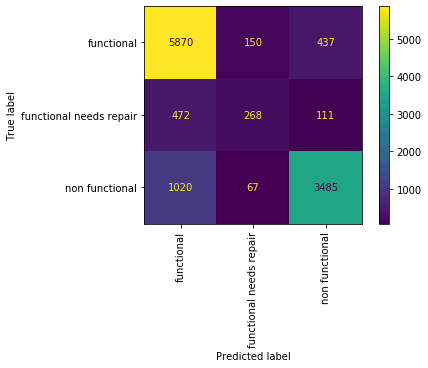

In [0]:
print('Validation Accuracy', pipeline.score(X_val, y_val))
plot_confusion_matrix(pipeline, X_val, y_val, 
                      values_format = ".0f",
                      xticks_rotation='vertical')

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_val,y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.91      0.85      6457
functional needs repair       0.55      0.31      0.40       851
         non functional       0.86      0.76      0.81      4572

               accuracy                           0.81     11880
              macro avg       0.74      0.66      0.69     11880
           weighted avg       0.81      0.81      0.80     11880



# New Section

In [0]:
y_pred

array(['non functional', 'functional', 'functional', ...,
       'non functional', 'functional', 'functional'], dtype=object)

In [0]:
round(pd.DataFrame(pipeline.predict_proba(X_val)),2)

,0,1,2
0,0.00,0.01,0.99
1,0.81,0.02,0.16
2,0.78,0.14,0.08
3,0.44,0.06,0.51
4,0.95,0.01,0.04
...,...,...,...
11875,0.95,0.02,0.03
11876,0.42,0.04,0.55
11877,0.00,0.00,1.00
11878,0.49,0.11,0.41


In [0]:
pipeline.predict_proba(X_val)[:,0]>.4

array([False,  True,  True, ..., False,  True,  True])

True     8311
False    3569
dtype: int64

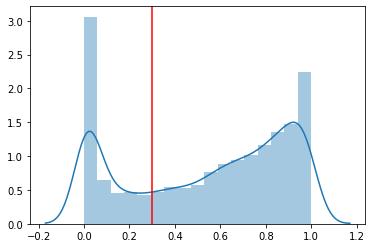

In [0]:
import seaborn as sns 

threshold = .3
y_pred_proba = pipeline.predict_proba(X_val)[:,0]
y_pred = y_pred_proba > threshold

ax = sns.distplot(y_pred_proba)
ax.axvline(threshold, color='red');

pd.Series(y_pred).value_counts()